# Cloud motion data over EPCAPE at the Pier

Downloads cloud motion data and plots means magnitude and direction of cloud movement for different segment ranks. The segment of rank 1 is the largest cloud motion area. The plots show the smoothed (10 minute running means) magnitude of cloud motion.  Arrows are used to indicate the direction of cloud movement at each time point for clear visualization of directional changes.  We try to use consistent colors for each rank.

In [13]:
import sage_data_client

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## Download from Sage Beehive

In [14]:


df = sage_data_client.query(
    start="2024-01-08T00:00:09Z",
    end="2024-02-29T23:23:24Z", 
    filter={
        "plugin": "registry.sagecontinuum.org/bhupendraraut/cloud-motion.*",
        "vsn": "W056"
    }
)
df.head()



,timestamp,name,value,meta.channel,meta.host,meta.image_frac,meta.input,meta.job,meta.node,meta.nsegments_asked,meta.nsegments_found,meta.plugin,meta.quality,meta.seg_id,meta.seg_rank,meta.seg_size,meta.task,meta.vsn,meta.zone
0,2024-02-08 13:02:58.248909416+00:00,cmv.mean.dir.degn,42.638695,0,000048b02d3af49f.ws-nxcore,0.9,top_camera,cloud-motion-v1-368,000048b02d3af49f,100,100,registry.sagecontinuum.org/bhupendraraut/cloud...,2,19,2,28062,cloud-motion-v1,W056,core
1,2024-02-08 13:02:58.248909416+00:00,cmv.mean.dir.degn,80.830643,0,000048b02d3af49f.ws-nxcore,0.9,top_camera,cloud-motion-v1-368,000048b02d3af49f,100,100,registry.sagecontinuum.org/bhupendraraut/cloud...,2,30,1,37333,cloud-motion-v1,W056,core
2,2024-02-08 13:02:58.248909416+00:00,cmv.mean.dir.degn,82.148445,0,000048b02d3af49f.ws-nxcore,0.9,top_camera,cloud-motion-v1-368,000048b02d3af49f,100,100,registry.sagecontinuum.org/bhupendraraut/cloud...,2,31,5,26331,cloud-motion-v1,W056,core
3,2024-02-08 13:02:58.248909416+00:00,cmv.mean.dir.degn,80.253082,0,000048b02d3af49f.ws-nxcore,0.9,top_camera,cloud-motion-v1-368,000048b02d3af49f,100,100,registry.sagecontinuum.org/bhupendraraut/cloud...,2,40,3,26689,cloud-motion-v1,W056,core
4,2024-02-12 12:50:09.365323194+00:00,cmv.mean.dir.degn,224.556030,0,000048b02d3af49f.ws-nxcore,0.9,top_camera,cloud-motion-v1-368,000048b02d3af49f,100,100,registry.sagecontinuum.org/bhupendraraut/cloud...,2,60,1,35901,cloud-motion-v1,W056,core


In [15]:
df['name'].unique()

array(['cmv.mean.dir.degn', 'cmv.mean.mag.pxpm', 'cmv.median.dir.degn',
       'cmv.median.mag.pxpm', 'cmv.motion.detected', 'cmv.thresh.otsu'],
      dtype=object)

In [16]:

# 1. Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 2. Round timestamps to the nearest minute
df['time'] = df['timestamp'].dt.round('1min')

## Plot cleaned data

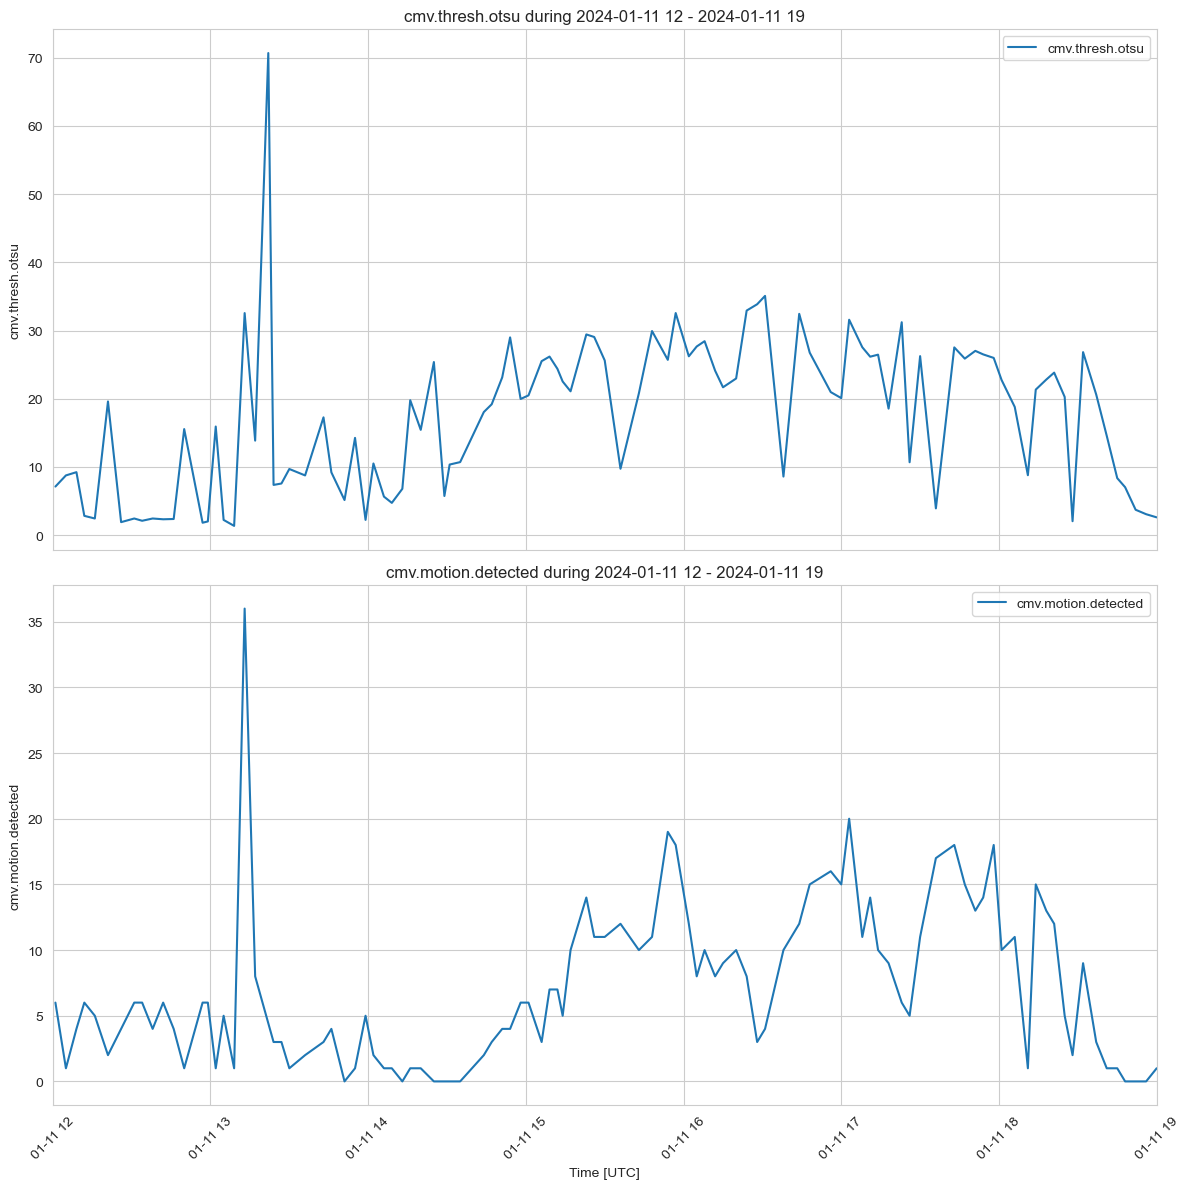

In [17]:
variables_to_plot = ['cmv.thresh.otsu', 'cmv.motion.detected']
start_date = '2024-01-11 12'
end_date = '2024-01-11 19'

fig, axes = plt.subplots(nrows=len(variables_to_plot), ncols=1, figsize=(12, 6 * len(variables_to_plot)), sharex=True)
sns.set_style("whitegrid")

for idx, variable_name in enumerate(variables_to_plot):
    ax = axes[idx]
    filtered_df = df[df['name'] == variable_name].copy()

    if not filtered_df.empty:
        filtered_df['time'] = pd.to_datetime(filtered_df['time'])
        filtered_df = filtered_df.sort_values('time')
        mask = (filtered_df['time'] >= start_date) & (filtered_df['time'] <= end_date)
        filtered_df = filtered_df[mask]
        sns.lineplot(x=filtered_df['time'], y='value', data=filtered_df, ax=ax, label=variable_name)

    ax.set_ylabel(variable_name)
    ax.set_xlabel('Time [UTC]')
    ax.set_title(f'{variable_name} during {start_date} - {end_date}')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

plt.tight_layout()
plt.show()


## Now plot direction and magnitude for a couple of top ranking segments

In [18]:

df_pivoted = df.pivot_table(
    index=['time', 'meta.seg_rank'], 
    columns='name',                              
    values='value'
).reset_index()                                

df_pivoted.head()

name,time,meta.seg_rank,cmv.mean.dir.degn,cmv.mean.mag.pxpm,cmv.median.dir.degn,cmv.median.mag.pxpm
0,2024-01-08 12:01:00+00:00,1,95.082756,2.764637,72.408264,2.135076
1,2024-01-08 12:01:00+00:00,2,203.766068,2.250856,215.368774,2.035495
2,2024-01-08 12:01:00+00:00,3,251.994751,2.695916,261.350098,2.359098
3,2024-01-08 12:04:00+00:00,1,231.746689,2.321195,250.504517,2.073656
4,2024-01-08 12:04:00+00:00,2,137.106461,2.424563,120.544800,2.299247


In [19]:
df_plot = df_pivoted.copy()
df_plot['meta.seg_rank'] = df_plot['meta.seg_rank'].astype(str)
variables_to_plot = ['cmv.mean.dir.degn', 'cmv.mean.mag.pxpm']
start_date = '2024-01-11 12'
end_date = '2024-01-11 19'
rank_colors = {"1": "blue", "2": "red", "3": "green", "4": "orange", "5": "purple", "6": "brown"}


In [20]:
df_plot.columns

Index(['time', 'meta.seg_rank', 'cmv.mean.dir.degn', 'cmv.mean.mag.pxpm',
       'cmv.median.dir.degn', 'cmv.median.mag.pxpm'],
      dtype='object', name='name')

In [21]:
start_date = '2024-01-11 12'
end_date = '2024-01-11 19'

rank_colors = {"1": "blue", "2": "red", "3": "green", "4": "orange", "5": "purple", "6": "brown"}


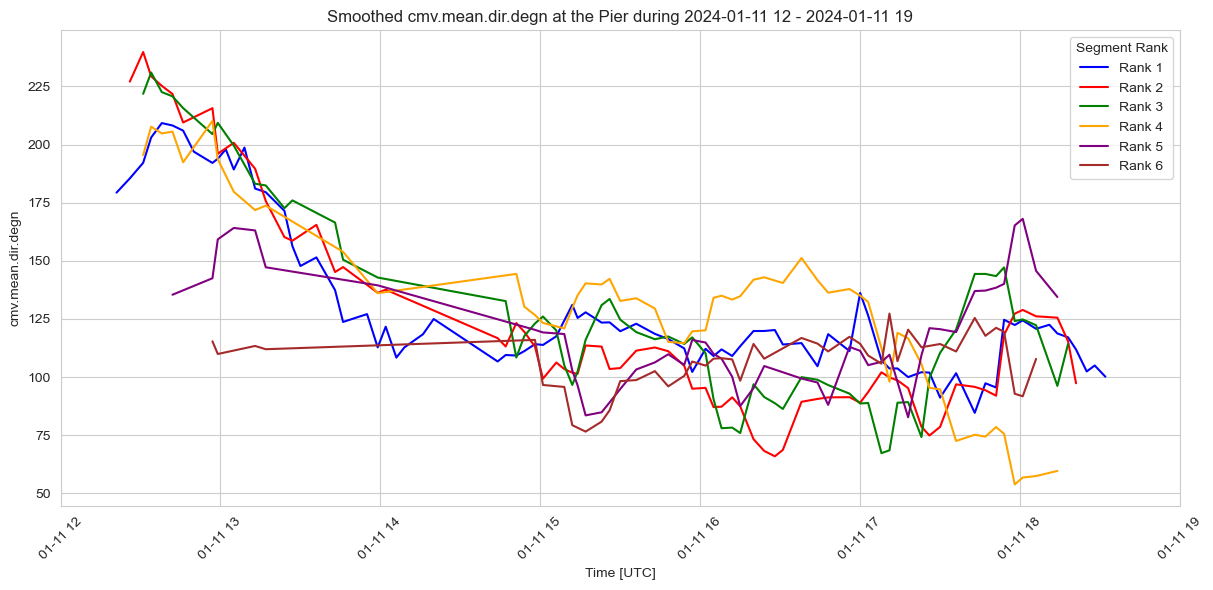

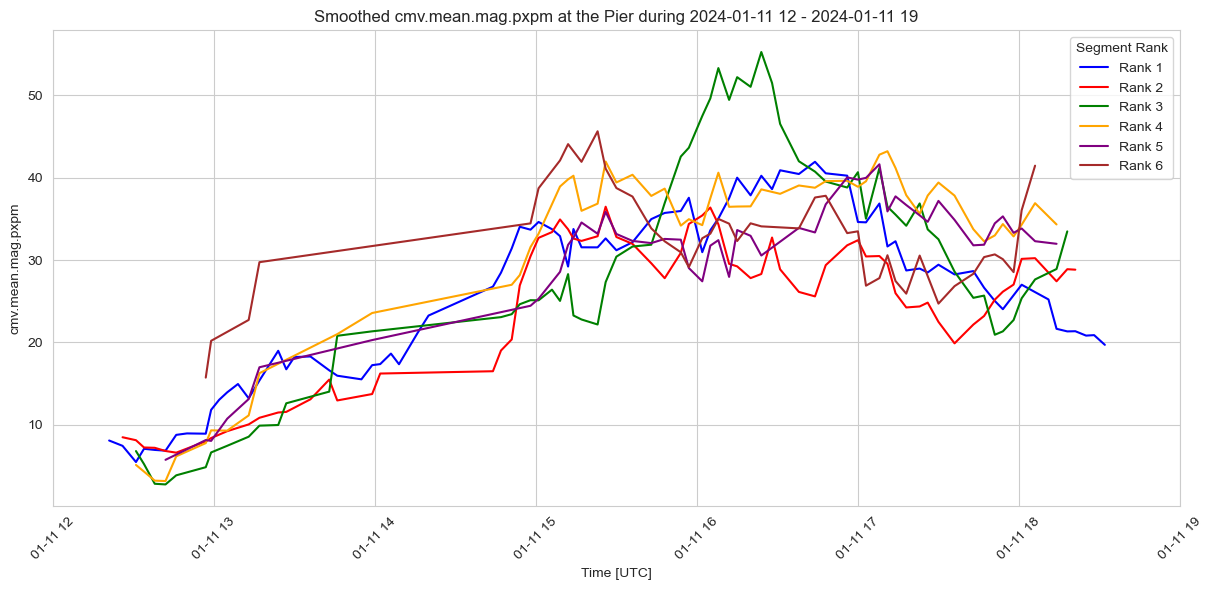

In [22]:


for variable_name in variables_to_plot:
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    for rank, color in rank_colors.items():
        rank_data = df_plot[df_plot['meta.seg_rank'] == rank].copy()

        if not rank_data.empty:
            rank_data['time'] = pd.to_datetime(rank_data['time'])
            rank_data = rank_data.sort_values('time')

            # Filter by date range
            mask = (rank_data['time'] >= start_date) & (rank_data['time'] <= end_date)
            rank_data = rank_data[mask]

            rank_data['smoothed_value'] = rank_data[variable_name].rolling(window=10, center=True).mean()

            sns.lineplot(x=rank_data['time'], y='smoothed_value', data=rank_data, color=color, label=f'Rank {rank}')


    plt.ylabel(variable_name)
    plt.xlabel('Time [UTC]')
    plt.title(f'Smoothed {variable_name} at the Pier during {start_date} - {end_date}') # Updated title
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='Segment Rank')


    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

    plt.show()

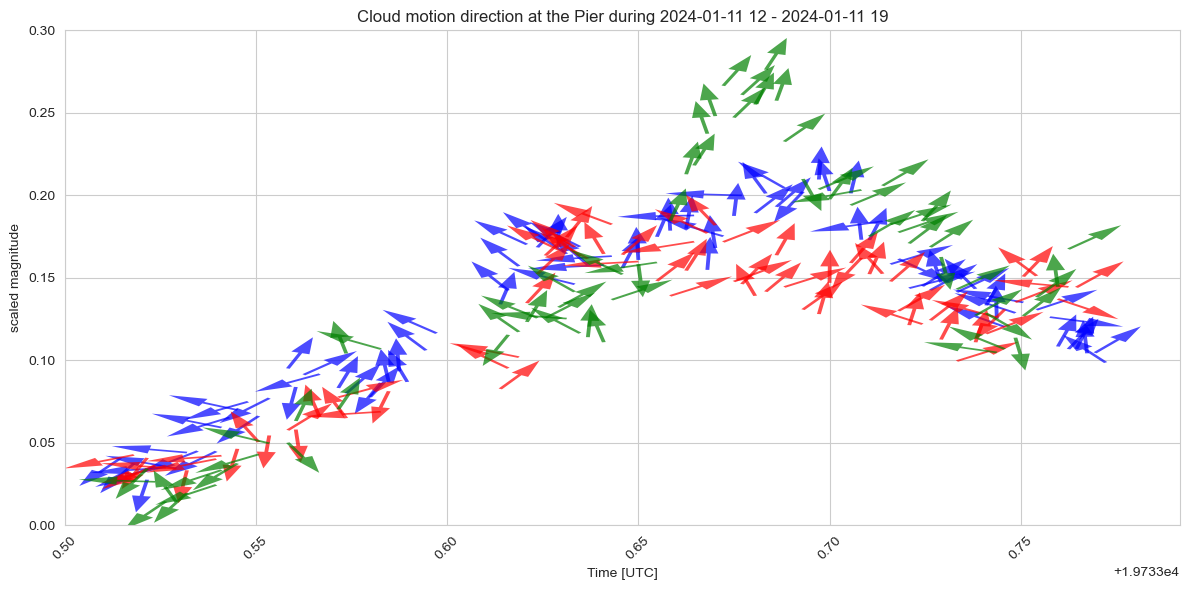

In [29]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_plot = df_pivoted.copy() 

df_plot['meta.seg_rank'] = df_plot['meta.seg_rank'].astype(str)

mag_variable = 'cmv.mean.mag.pxpm'
dir_variable = 'cmv.mean.dir.degn'
variables_to_plot = [mag_variable] 

start_date = '2024-01-11 12'  
end_date = '2024-01-11 19'   

rank_colors = {"1": "blue", "2": "red", "3": "green"}  

arrow_length = 0.01  
arrow_head_width = 0.005
arrow_head_length = 0.01
arrow_line_width = 0.01
magnitude_scale = 0.005 

for variable_name in variables_to_plot: 
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    for rank, color in rank_colors.items():
        rank_data = df_plot[df_plot['meta.seg_rank'] == rank].copy()

        if not rank_data.empty:
            rank_data['time'] = pd.to_datetime(rank_data['time'])
            rank_data = rank_data.sort_values('time')

            mask = (rank_data['time'] >= start_date) & (rank_data['time'] <= end_date)
            rank_data = rank_data[mask]

            rank_data['smoothed_mag'] = rank_data[mag_variable].rolling(window=10, center=True).mean()
            rank_data_arrow = rank_data.dropna(subset=['smoothed_mag', dir_variable]) 

            for index, row in rank_data_arrow.iterrows():
                time_val = row['time']
                magnitude_val = row['smoothed_mag'] * magnitude_scale 
                direction_deg = row[dir_variable]

                direction_rad = np.deg2rad(direction_deg)

                dx = arrow_length * np.cos(direction_rad)
                dy = arrow_length * np.sin(direction_rad)

                plt.arrow(time_val, magnitude_val, dx, dy,
                          head_width=arrow_head_width, head_length=arrow_head_length,
                          fc=color, ec=color, linewidth=arrow_line_width, alpha=0.7) 

    plt.ylabel('scaled magnitude') 
    plt.xlabel('Time [UTC]')
    plt.title(f'Cloud motion direction at the Pier during {start_date} - {end_date}') 
    plt.xticks(rotation=45)
    plt.tight_layout()
    #plt.legend(title='Segment Rank')

    plt.ylim(0, 0.3) 
    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

    plt.show()